<a href="https://colab.research.google.com/github/SHSoniHS/SHSoniHS/blob/main/MODELO_FORTIA_10Nov2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## FORTIA - MODELO de Clasificacion de imágenes con Redes Neuronales Convolucionales pre-aprendidas o con Transfer-Learning

1. Instalación de paquetes
Primero se instalan los paquetes de Python para su uso posterior.

torch: PyTorch es un paquete de Python que proporciona dos características de alto nivel:
     (1) Computación de Tensores (como NumPy) con gran potencia de GPU.
     (2) Deep Neural Networks o Redes Neuronales Profundas construidas sobre un sistema de
         autogradiente o tape-based autograd system.

torchvision: El paquete torchvision contiene los conjuntos de datos o datasets populares,
             arquitecturas de modelos, y transformaciones comunes de imágenes para visión
             artificial o por ordenador.

matplotlib: Matplotlib es una librería para gráficos y una extensión numérica con funciones
            matemáticas de la librería Numpy.

In [ ]:
%pip install torch
%pip install torchvision
%pip install matplotlib
#%pip install sklearn
%pip install scikit-learn
#%pip install tabulate


In [ ]:
# Importación de las bibliotecas necesarias
# Torch: La biblioteca principal para el trabajo con tensores y modelos en PyTorch
# torch.nn: Contiene módulos y funciones que permiten construir redes neuronales
# torch.optim: Proporciona algoritmos de optimización
# torch.nn.functional: Contiene funciones que no requieren instancias de clase,
# como funciones de activación
# torchvision: Proporciona utilidades para trabajar con datos de visión artificial,
# incluyendo conjuntos de datos predefinidos y transformaciones
# PIL: Utilizada para abrir y manipular imágenes
# os: Permite interactuar con el sistema operativo, p.ej. para acceder a archivos y directorios
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import os
import pandas as pd
import random
import matplotlib.pyplot as plt
from datetime import datetime

from termcolor import colored
from torchvision import datasets, transforms, models
from torch.utils.data import random_split, DataLoader
from PIL import Image
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report


# Configuración del dispositivo: usa GPU si está disponible, sino, CPU
# En el contexto de PyTorch, cuda se refiere a la tecnología de computación paralela
# desarrollada por NVIDIA que permite a las GPU (tarjetas gráficas) realizar
# cálculos intensivos más rápido que las CPU.
# Use is_available() to determine if your system supports CUDA.
#if torch.cuda.is_available():
#    device = "cuda:0"
#else:
#    device = "cpu"
#print("Usando dispositivo:", device)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", device)


Usando dispositivo: cuda


In [ ]:
# LOCALIZAMOS LOS DIRECTORIOS DONDE ESTÁN LAS IMAGENES

# Obtener el directorio actual
cwd_directory = os.getcwd()
print(f"Directorio de trabajo en uso: {cwd_directory}")

# Nombre de mi directorio de trabajo
current_directory = '/home/studio-lab-user/sagemaker-studiolab-notebooks/studio-lab-examples/generative-ai/FORTIA-MODELO'
print(f"Directorio actual: {current_directory}")

# Cambia el directorio de trabajo
os.chdir(current_directory)

# Verifica el directorio actual
print("Directorio de trabajo actual:", os.getcwd())

# Nombre de la carpeta donde se almacenan las imágenes
image_folder = "FORTIA-DATA"
print(f"Directorio de las imagenes: {image_folder}")

# Crear la ruta completa a la carpeta de imágenes
#image_folder_path = 'ruta/al/directorio-de-imagenes'
image_folder_path = os.path.join(current_directory, image_folder)

# Verificar si la carpeta existe
if os.path.exists(image_folder_path):
    print(f"La carpeta de imágenes se encuentra en: {image_folder_path}")
else:
    print(f"La carpeta '{image_folder_path}' no existe en el directorio actual.")
    # Si es necesario, se puede crear la carpeta
    # os.makedirs(image_folder_path)
    # print(f"Carpeta '{image_folder}' creada en: {image_folder_path}")

print("Contenido del directorio:")
print(os.listdir(image_folder_path))


Directorio de trabajo en uso: /home/studio-lab-user/sagemaker-studiolab-notebooks/studio-lab-examples/generative-ai/FORTIA-MODELO
Directorio actual: /home/studio-lab-user/sagemaker-studiolab-notebooks/studio-lab-examples/generative-ai/FORTIA-MODELO
Directorio de trabajo actual: /home/studio-lab-user/sagemaker-studiolab-notebooks/studio-lab-examples/generative-ai/FORTIA-MODELO
Directorio de las imagenes: FORTIA-DATA
La carpeta de imágenes se encuentra en: /home/studio-lab-user/sagemaker-studiolab-notebooks/studio-lab-examples/generative-ai/FORTIA-MODELO/FORTIA-DATA
Contenido del directorio:
['CASTELLON-PENISCOLA', 'HUESCA-LOARRE', 'SEGOVIA-ALCAZAR', 'MADRID-MANZANARES']


In [ ]:
# CARGA DE LAS IMAGENES PARA ENTRENAR EL MODELO
# CARGA DE DATOS
# Carga de las imágenes desde el directorio local
# La estructura de carpetas debe ser:
# data/
# ├── Tipo-001/
# ├── Tipo-002/
# ├── Tipo-003/
# └── Tipo-004/

from torch.utils.data import ConcatDataset
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Definición de las transformaciones para preprocesar las imágenes
transform = transforms.Compose([
    transforms.Lambda(lambda img: img.convert('RGB')),  # Convierte imágenes RGBA a RGB

    transforms.Resize((224, 224)),  # Redimensiona las imágenes a 224x224 píxeles

    # Redimensionar las imágenes a 224x224 píxeles, que es el tamaño de entrada
    # esperado por modelos como ResNet con un recorte aleatorio en diferentes escalas
    #transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),

    # Data Augmentation:
    # Transformaciones aleatorias para aumentar la diversidad de los datos de entrenamiento
    #transforms.RandomHorizontalFlip(),  # Invierte la imagen horizontalmente con probabilidad de 0.5
    transforms.RandomRotation(5),      # Rota la imagen aleatoriamente entre -5 y 5 grados
    transforms.ColorJitter(             # Modifica brillo, contraste, saturación y tono para crear variaciones
        brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1
    ),

    transforms.ToTensor(),  # Convierte las imágenes en tensores que son las estructuras que usa PyTorch
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalización
    # Normaliza las imágenes utilizando los valores medios y desviaciones estándar de los
    # conjuntos de datos ImageNet, lo que ayuda a estabilizar el entrenamiento.
])


# Función para cargar las imágenes ignorando carpetas no deseadas
# Esta función load_dataset cargará todas las imágenes válidas, organizará las clases
# y preparará el conjunto de datos para entrenar un modelo de clasificación de imágenes.
def load_dataset(image_folder_path):
    # Verificar si el directorio existe
    if not os.path.exists(image_folder_path):
        print(f"Error: El directorio {image_folder_path} no existe.")
        return None

    try:
        # Cargar el dataset directamente desde el directorio principal
        dataset = datasets.ImageFolder(root=image_folder_path, transform=transform)

        tam_batch = 16
        print (f"El tamaño del batch es de: {tam_batch}")

        # División del conjunto de datos en 80% para entrenamiento y 20% para validación
        train_size = int(0.8 * len(dataset))
        val_size = len(dataset) - train_size
        train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

        # Crear DataLoaders para el conjunto de entrenamiento
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=tam_batch, shuffle=True)
        # Crear DataLoader para el conjunto de validación
        validation_loader = torch.utils.data.DataLoader(val_dataset, batch_size=tam_batch, shuffle=False)


        print(f"Tamaño del conjunto de entrenamiento: {len(train_dataset)} imágenes")
        print(f"Tamaño del conjunto de validación: {len(val_dataset)} imágenes")
        print(f"Tamaño del conjunto de entrenamiento aumentado: {len(train_loader)} imágenes")
        print(f"Tamaño del conjunto de validación: {len(validation_loader)} imágenes")


        # Información sobre el dataset
        print(f'Total de imágenes en el conjunto de entrenamiento: {len(dataset)}')
        num_classes = len(dataset.classes)
        print(f'Número de clases en el dataset: {num_classes}')
        print(f'Número de batches: {len(train_loader)}')

        # Contar imágenes por clase
        class_counts = {class_name: 0 for class_name in dataset.classes}
        for _, label in dataset.samples:
            class_name = dataset.classes[label]
            class_counts[class_name] += 1

        print("Número de imágenes por clase:")
        for class_name, count in class_counts.items():
            print(f"  Clase '{class_name}': {count} imágenes")

        return train_loader, validation_loader, num_classes, dataset  # Devolver ambos DataLoaders y el número de clases

    except FileNotFoundError as e:
        print("Error al cargar el dataset:", e)
        return None
# Fin de la función load_dataset


# Imprimo el path a considerar
print(f"La carpeta de imágenes se encuentra en: {image_folder_path}")

# Usar la función load_dataset
train_loader, validation_loader, num_classes, dataset = load_dataset(image_folder_path)

train_dataset = train_loader.dataset  # Obtener el dataset de entrenamiento desde el DataLoader
validation_dataset = validation_loader.dataset # Obtener el dataset de valiadacion desde el DataLoader


La carpeta de imágenes se encuentra en: /home/studio-lab-user/sagemaker-studiolab-notebooks/studio-lab-examples/generative-ai/FORTIA-MODELO/FORTIA-DATA
El tamaño del batch es de: 16
Tamaño del conjunto de entrenamiento: 176 imágenes
Tamaño del conjunto de validación: 44 imágenes
Tamaño del conjunto de entrenamiento aumentado: 11 imágenes
Tamaño del conjunto de validación: 3 imágenes
Total de imágenes en el conjunto de entrenamiento: 220
Número de clases en el dataset: 4
Número de batches: 11
Número de imágenes por clase:
  Clase 'CASTELLON-PENISCOLA': 54 imágenes
  Clase 'HUESCA-LOARRE': 55 imágenes
  Clase 'MADRID-MANZANARES': 55 imágenes
  Clase 'SEGOVIA-ALCAZAR': 56 imágenes


In [ ]:
# DEFINICION DEL MODELO CON TRANSFER LEARNING
# Carga del modelo preentrenado ResNet18
#model = models.resnet18(pretrained=True)
# Carga del modelo preentrenado ResNet18 con los pesos actualizados
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Congelamos las capas de la red para que no se actualicen sus pesos en el entrenamiento
for param in model.parameters():
    param.requires_grad = False

# Modificación de la última capa para que tenga n salidas (una para cada tipo o clase a clasificar)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, num_classes)  # n clases de salida

# Descongelar la última capa para que se actualice en el entrenamiento
for param in model.fc.parameters():
    param.requires_grad = True  # Asegurarnos de que los parámetros de la última capa
    #pueden ser actualizados

# Mover el modelo al dispositivo especificado
model = model.to(device)

print(f"Modelo con Transfer Learning configurado para clasificación en {num_classes} clases.")


Modelo con Transfer Learning configurado para clasificación en 4 clases.


In [ ]:
# CREAR TABLAS de recopilacion de métricas como resumen de la precisión dle modelo
# Son funciones que puedo luego aplicar a entrenamiento y validacion
# así podré compararlas y detectar si hay overfitting o sobreajuste .

from termcolor import colored
#from tabulate import tabulate

# Dataframe global para almacenar las precisiones del entrenamiento
precisiones_entrenamiento = pd.DataFrame(columns=['Epoca', 'Precisión'])
# Dataframe global para almacenar las precisiones de la validacion
precisiones_validacion = pd.DataFrame(columns=['Epoca', 'Precisión'])

def actualizar_precisiones(epoch, valor_obtenido, total_precisiones):
    """
    Actualiza las tablas de precisiones para entrenamiento y validación.

    Parameters:
    - epoch: Número de la época.
    - valor_obtenido: Valor de precision a almacenar en total_precisiones.
    - total_precisiones: Dataframe donde se van añadiendo las precisiones calculadas
    """
    valor_obtenido = f"{valor_obtenido:.2f}"

    # Añadir las precisiones de cada época en las listas correspondientes
    # Creando un nuevo DataFrame con la nueva fila a añadir
    nueva_fila = pd.DataFrame({'Epoca': [epoch + 1], 'Precisión': [valor_obtenido]})

    # Añadir la nueva fila al DataFrame total_precisiones
    total_precisiones = pd.concat([total_precisiones, nueva_fila], ignore_index=True)

    # Listar el contenido de total_precisiones después de la concatenación
    #print("Contenido de total_precisiones después de la concatenación:")
    #print(total_precisiones)

    return total_precisiones


In [ ]:
# ENTRENAMIENTO DEL MODELO Y EVALUACION DEL MODELO

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# ENTRENAMIENTO DEL MODELO:
# Función para entrenar el modelo en una única época
def entrenar_modelo(model, train_loader, criterion, optimizer, device):
    model.train()  # Establecer el modelo en modo de entrenamiento
    running_loss = 0.0
    correct = 0
    total = 0

    # Iterar sobre el conjunto de entrenamiento
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()  # Reiniciar los gradientes
        outputs = model(images)  # Paso hacia adelante

        loss = criterion(outputs, labels)  # Calcular la pérdida
        loss.backward()  # Paso hacia atrás (gradientes)
        optimizer.step()  # Actualizar los pesos

        running_loss += loss.item()

        # Calcular la precisión
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Precisión del entrenamiento
    train_accuracy = 100 * correct / total if total > 0 else 0
    return running_loss / len(train_loader), train_accuracy

# EVALUACION DEL MODELO
# Función para evaluar el modelo en el conjunto de validación
def evaluar_modelo(model, validation_loader, device):
    model.eval()  # Poner el modelo en modo de evaluación
    all_preds = []  # Lista para almacenar todas las predicciones
    all_labels = [] # Lista para almacenar todas las etiquetas verdaderas

    # Desactivar gradientes para ahorrar memoria
    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            # Prediccion del modelo
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            # lmacenar predicciones y etiquetas
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calcular las métricas
    accuracy = accuracy_score(all_labels, all_preds)
    #Activo zero_division para evitar UndefinedMetricWarning y
    #configurar las clases no predichas como 0,
    #para tratar las clases no predichas de otra manera se asignaría un valor diferente a zero_division
    #precision = precision_score(all_labels, all_preds, average='weighted')
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    # Reporte de clasificación por clase
    report = classification_report(all_labels, all_preds, target_names=validation_loader.dataset.dataset.classes)
    print("Reporte de clasificación por clase:\n", report)

    # Precisión de validacion
    val_accuracy = 100 * accuracy

    return val_accuracy, accuracy, precision, recall, f1

# Configuración de la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)  # Solo optimizamos la última capa
# Notese que uso una tasa de aprendizaje o learning rate o lr de 0.001

############# SELECCION DEL NUMERO DE EPOCAS O BUCLES DE ENTRENAMIENTO ##################
num_epochs = 10

# Variables para acumular las métricas globales
global_train_accuracy = 0.0
global_accuracy = 0.0
global_precision = 0.0
global_recall = 0.0
global_f1 = 0.0

# Ciclo de entrenamiento y evaluación
for epoch in range(num_epochs):
    print(f"\nEntrenando la época {epoch+1}/{num_epochs}")

    # Entrenamiento del modelo durante una época
    epoch_loss, train_accuracy = entrenar_modelo(model, train_loader, criterion, optimizer, device)
    # Imprimimos la pérdida promedio de la época y la precisión
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {train_accuracy:.2f}%')

    # Evaluación después de cada época en el conjunto de validación
    validation_accuracy, accuracy, precision, recall, f1 = evaluar_modelo(model, validation_loader, device)

    #Actualizar la tabla de precisiones en entrenamiento para luego mostrar el resumen
    precisiones_entrenamiento = actualizar_precisiones(epoch, train_accuracy, precisiones_entrenamiento)

    #Actualizar la tabla de precisiones en validacion para luego mostrar el resumen
    precisiones_validacion = actualizar_precisiones(epoch, validation_accuracy, precisiones_validacion)

    # Mostrar los resultados de la evaluación por época
    print(f"\nEpoca {epoch + 1}/{num_epochs}")
    print(f"Precisión global: {accuracy:.4f}")
    print(f"Precisión (precision): {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print("-" * 50)

    # Acumulando métricas globales
    global_train_accuracy += train_accuracy
    global_accuracy += accuracy
    global_precision += precision
    global_recall += recall
    global_f1 += f1

# Mostrar métricas globales para todas las épocas
print("\nMétricas Globales (promedio):")
print(f"Precisión global promedio: {global_accuracy / num_epochs:.4f}")
print(f"Precisión (precision) promedio: {global_precision / num_epochs:.4f}")
print(f"Recall promedio: {global_recall / num_epochs:.4f}")
print(f"F1-Score promedio: {global_f1 / num_epochs:.4f}")
print("-" * 50)



Entrenando la época 1/5
Epoch [1/5], Loss: 1.4116, Accuracy: 33.52%
Reporte de clasificación por clase:
                      precision    recall  f1-score   support

CASTELLON-PENISCOLA       0.80      0.24      0.36        17
      HUESCA-LOARRE       0.21      0.38      0.27         8
  MADRID-MANZANARES       0.42      0.89      0.57         9
    SEGOVIA-ALCAZAR       0.67      0.40      0.50        10

           accuracy                           0.43        44
          macro avg       0.53      0.47      0.43        44
       weighted avg       0.59      0.43      0.42        44


Epoca 1/5
Precisión global: 0.4318
Precisión (precision): 0.5857
Recall: 0.4318
F1-Score: 0.4206
--------------------------------------------------

Entrenando la época 2/5
Epoch [2/5], Loss: 1.2216, Accuracy: 45.45%
Reporte de clasificación por clase:
                      precision    recall  f1-score   support

CASTELLON-PENISCOLA       1.00      0.53      0.69        17
      HUESCA-LOARRE      

In [ ]:
# Funcion para mostrar el resumen de precisiones en entrenamiento y validacion
def mostrar_tabla_resumen(df, tabla_nombre="Tabla Resumen"):
    """
    Muestra cualquier tabla de precisión de forma visualmente atractiva.

    Parámetros:
    - df: DataFrame de pandas con los datos a mostrar.
    - tabla_nombre: Nombre opcional para la tabla a mostrar.
                    Por defecto si no se indica nada pondrá simplemente "Tabla Resumen"
    """
    # Asegurarnos de que df es un DataFrame
    #if isinstance(df, list):
    #    df = pd.DataFrame(df)

    # Generar un color aleatorio para la tabla
    colores = ['red', 'green', 'yellow', 'blue', 'magenta', 'cyan', 'white']
    #color_fondo = random.choice(colores)
    # Usar el formato adecuado para el color de fondo
    color_fondo = random.choice([f'on_{color}' for color in colores])

    # Mostrar título de la tabla con color
    print(colored(f"\n{tabla_nombre}:", color="black", on_color=color_fondo, attrs=["bold"]))

    # Convertir cada valor en una cadena centrada de ancho 15
    df_formateado = df.astype(str).apply(lambda x: x.str.center(15))
    # Convertir los nombres de las columnas a cadenas y luego centrarlas
    df_formateado.columns = [str(col).center(15) for col in df.columns]

    # Mostrar el dataframe formateado
    #print(df_formateado)

    # Mostrar los nombres de las columnas
    #print("Nombres de columnas en el DataFrame:", df.columns)

    # OPCION 1: Convertir el DataFrame formateado a string y mostrar con el color de fondo
    df_string = df_formateado.to_string(index=False, col_space=15)
     # Mostrar la tabla con formato
    print(colored(df_string, color="black", on_color=color_fondo))

    # OPCION 2: Convertir el DataFrame formateado a una tabla con bordes usando `tabulate`
    #tabla_con_bordes = tabulate(df_formateado, headers="keys", tablefmt="grid", stralign="center")
     # Mostrar la tabla con formato
    #print(colored(tabla_con_bordes, color="black", on_color=color_fondo))


    # Encontrar la época con la precisión máxima en la segunda columna
    epoca_maxima = df.iloc[:, 1].idxmax()      # Índice de la fila con el valor máximo en la segunda columna
    precision_maxima = df.iloc[:, 1].max()     # Valor máximo en la segunda columna

    # Mostrar la época y precisión máxima
    print(f"\nÉpoca con la precisión máxima: {epoca_maxima + 1}")
    print(f"Precisión máxima alcanzada: {precision_maxima}")

#PARA PROBAR LA TABLA COMO SE VERÁ:
# Crear un DataFrame de ejemplo
#datos_ejemplo = {
#        "Epoca": [1, 2, 3, 4, 5],
#        "Precisión Entrenamiento": [0.75, 0.80, 0.82, 0.85, 0.88],
#        "Precisión Validación": [0.70, 0.78, 0.79, 0.83, 0.85]
#}
#df_ejemplo = pd.DataFrame(datos_ejemplo)
#
#mostrar_tabla_resumen(df_ejemplo, tabla_nombre="Tabla Resumen de Ejemplo")


# Comprobar los tipos y cabeceras
#print(type(precisiones_entrenamiento))
#print(precisiones_entrenamiento.head())
#print(type(precisiones_validacion))
#print(precisiones_validacion.head())

# Mostrar conjunto de datos por cada epoca todos juntos
# Para entrenamiento:
mostrar_tabla_resumen(precisiones_entrenamiento, tabla_nombre="Tabla Resumen de Entrenamiento:")
# Para validación:
mostrar_tabla_resumen(precisiones_validacion, tabla_nombre="Tabla Resumen de Validacion:")



Tabla Resumen de Entrenamiento::
     Epoca         Precisión   
       1             33.52     
       2             45.45     
       3             54.55     
       4             59.66     
       5             70.45     

Época con la precisión máxima: 5
Precisión máxima alcanzada: 70.45

Tabla Resumen de Validacion::
     Epoca         Precisión   
       1             43.18     
       2             54.55     
       3             56.82     
       4             65.91     
       5             75.00     

Época con la precisión máxima: 5
Precisión máxima alcanzada: 75.00


Precisión de Entrenamiento:   Epoca Precisión
0     1     33.52
1     2     45.45
2     3     54.55
3     4     59.66
4     5     70.45
Precisión de Validación:   Epoca Precisión
0     1     43.18
1     2     54.55
2     3     56.82
3     4     65.91
4     5     75.00
Precisión de Entrenamiento (convertida a float):
0    33.52
1    45.45
2    54.55
3    59.66
4    70.45
Name: Precisión, dtype: float64

Precisión de Validación (convertida a float):
0    43.18
1    54.55
2    56.82
3    65.91
4    75.00
Name: Precisión, dtype: float64


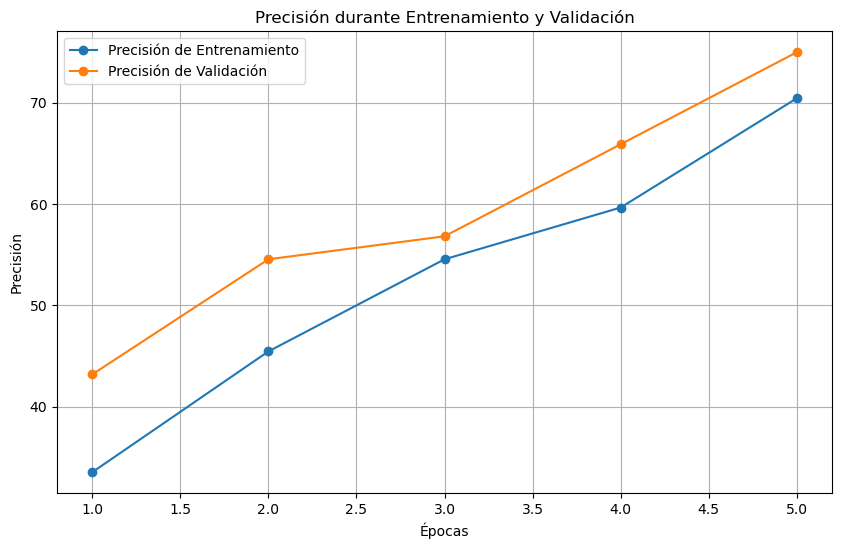

In [ ]:
# Convertir solo los valores numéricos a float, ignorando la cabecera
# que es formato texto o string
def convertir_a_float(val):
    try:
        return float(val)
    except ValueError:
        return val  # Si no puede convertirlo, se deja el valor tal cual porque será la cabecera.

# Imprimir los contenidos de las listas para verificar
print("Precisión de Entrenamiento:", precisiones_entrenamiento)
print("Precisión de Validación:", precisiones_validacion)


# Convertir la columna 'Precisión' a tipo float para ambos DataFrames
precisiones_entrenamiento['Precisión'] = pd.to_numeric(precisiones_entrenamiento['Precisión'], errors='coerce')
precisiones_validacion['Precisión'] = pd.to_numeric(precisiones_validacion['Precisión'], errors='coerce')

# Verificar que las conversiones a float hayan sido exitosas
print("Precisión de Entrenamiento (convertida a float):")
print(precisiones_entrenamiento['Precisión'])

print("\nPrecisión de Validación (convertida a float):")
print(precisiones_validacion['Precisión'])

# Generar gráfica de precisión de entrenamiento y validación
plt.figure(figsize=(10, 6))
epochs = range(1, len(precisiones_entrenamiento) + 1)

# Línea de precisión de entrenamiento
plt.plot(epochs, precisiones_entrenamiento['Precisión'], label='Precisión de Entrenamiento', marker='o')
# Línea de precisión de validación
plt.plot(epochs, precisiones_validacion['Precisión'], label='Precisión de Validación', marker='o')

# Configuraciones de la gráfica
plt.title('Precisión durante Entrenamiento y Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.grid(True)

# Mostrar la gráfica
plt.show()

In [ ]:
############# FUNCIÓN DE CLASIFICACIÓN CON UMBRAL DE CONFIANZA #################
# Variable global para almacenar clasificaciones diarias
clasificaciones_diarias = []

def classify_image(image, dataset, threshold=0.5):
    """
    Clasifica una imagen en una de las n clases conocidas o
    la etiqueta como 'No clasificable'
    si la confianza es menor que el umbral.
    """
    #print(f"La imagen a clasificar es: {image}")
    # Extraer el nombre del archivo
    file_name = os.path.basename(image_path)
    print(f"Nombre del archivo a clasificar: {file_name}")

    #Activo el modo evaluacion.
    model.eval()  # Cambiamos el modelo a modo de evaluación

    # Inicializar confianza para asegurarnos de que siempre tiene un valor
    confianza = 0.0

    with torch.no_grad():  # No calculamos gradientes en esta fase

        # Asegurar el mover la imagen al dispositivo correcto
        output = model(image.unsqueeze(0).to(device))

        # Convertimos las salidas en probabilidades
        probabilidades = F.softmax(output, dim=1)

        # Obtenemos la clase predicha
        #predicted_class = outputs.argmax(dim=1)
        max_prob, predicted_class = torch.max(probabilidades, 1)

        # Verificamos si la confianza supera el umbral
        if max_prob < threshold:
            clasificacion = "No clasificable, no se encuentra o identificacion fallida."
        else:
            clasificacion = dataset.classes[predicted_class.item()]
            print(f"La clase identificada es: {clasificacion}")
            #print(f"El nivel de confianza es: {max_prob}")
            confianza = max_prob.item() * 100
            print(f"El nivel de confianza es: {confianza:.2f}%")

    # Almacenamos la clasificación en una lista con fecha y hora
    clasificaciones_diarias.append({
           'fecha': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
           'imagen': image_path,  # Ruta o nombre del archivo de imagen
           'clasificacion': clasificacion,
            # Convertimos la probabilidad máxima a un valor float para almacenar
           'confianza': confianza
    })

    return clasificacion, confianza


In [ ]:
# PIL, originalmente, PIL (Python Imaging Library) fue una biblioteca creada para facilitar
# la manipulación de imágenes en Python. Sin embargo, dejó de ser mantenida y ya no recibe
# actualizaciones.
# Pillow es una versión moderna y mejorada de PIL. Pillow es un fork (una bifurcación) de PIL
# que agrega soporte para Python 3 y nuevas funcionalidades. Es ampliamente utilizado y
# recomendado para el trabajo con imágenes en Python.
# Permite abrir imagenes del disco
# Permite manipular imagenes mediante operaciones como redimensionar, rotas, aplicar filtros.
# Después de realizar modificaciones en una imagen permite guardarla en varios formatos.

# Cargar y preprocesar la imagen con la funcion siguiente:
def preprocess_image(image_path):
    # Comprobar si la ruta de la imagen existe
    if os.path.isfile(image_path):
        image = Image.open(image_path).convert("RGB")  # Convertir a RGB
        image = transform(image)  # Aplicar las transformaciones definidas
        return image
    else:
        print(f"La imagen no se encuentra en la ruta especificada: {image_path}")
        return None  # Devuelve None si la imagen no existe

# PRUEBA DE USO
# Define el directorio de imágenes y el nombre del archivo
image_dir = '/home/studio-lab-user/sagemaker-studiolab-notebooks/studio-lab-examples/generative-ai/FORTIA-MODELO/IMAGENES'
file_name = 'LOARRE-2.jpg'

# Concatenar el directorio y el nombre del archivo para formar la ruta completa
image_path = os.path.join(image_dir, file_name)

# Imprimir la ruta completa y el nombre del archivo
#print(f"Ruta completa de la imagen: {image_path}")
#print(f"Nombre del archivo a clasificar: {file_name}")

# Aplicamos las transformaciones a la imagen
image = preprocess_image(image_path)

if image is not None:  # Comprobar si la imagen se ha cargado correctamente
    result, confianza = classify_image(image, dataset)  # Clasificar la imagen solo si es válida
    # Imprimir el resultado de la clasificación
    print(f"Resultado de la Clasificación = {result}")
else:
    print("No se pudo clasificar la imagen debido a un error en la carga.")


Nombre del archivo a clasificar es: LOARRE-2.jpg
La clase identificada es: HUESCA-LOARRE
El nivel de confianza es: 52.50%
Resultado de la Clasificación = HUESCA-LOARRE


In [ ]:
#import csv
# No hace falta importar csv porque la libreria pandas sabe manejar ficheros csv

# La variable global para almacenar clasificaciones diarias ya fue declarada antes
# de la funcion de clasificacion
# clasificaciones_diarias = []

# Función para exportar las clasificaciones diarias a un archivo
def exportar_clasificaciones_diarias(nombre_fichero=None):
    """
    Exporta las clasificaciones diarias almacenadas en la variable clasificaciones_diarias
    a un archivo CSV.
    Si no se especifica un nombre de archivo, se utiliza un nombre por defecto
    con la fecha actual.
    Parámetros:
    - nombre_fichero (str): Nombre opcional del archivo de salida. Si no se proporciona,
    se genera un nombre con la fecha.
    """
    # Crear un nombre de archivo con fecha si no se ha proporcionado uno
    if nombre_fichero is None:
        nombre_fichero = f"clasificaciones_{datetime.now().strftime('%Y%m%d')}.csv"

    # Convertir las clasificaciones en un DataFrame de pandas
    df = pd.DataFrame(clasificaciones_diarias)

    # Exportar el DataFrame a un archivo CSV
    df.to_csv(nombre_fichero, index=False)
    print(f"Clasificaciones diarias exportadas a {nombre_fichero}")


In [ ]:
exportar_clasificaciones_diarias()

Clasificaciones diarias exportadas a clasificaciones_20241110.csv


In [ ]:
# Guardar el modelo
#model.save("model.h5")  # Para TensorFlow/Keras
torch.save(model.state_dict(), "modelo-FORTIA.pth")  # Para PyTorch
